In [1]:
import numpy as np
import scipy
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorcet as cc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from ActiveSet.activeset import *

ModuleNotFoundError: No module named 'ActiveSet'

# In unit circle


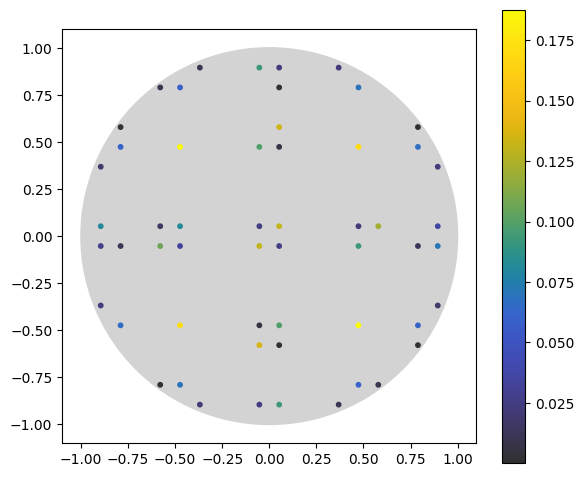

In [99]:
m = 10
M = 20

# Monomials and q(P^(j)) and its integral and partial derivatives 
def ps(n):
    p , q= [] , []
    px , py = [] , []
    for i in range(n):
        for j in range(n-i):
            p.append((i , j))
            # Partial derivative w.r.t. x
            if i == 0:
                px.append(0)
            else:
                px.append((i-1,j))
            # Partial derivative w.r.t. y
            if j == 0:
                py.append(0)
            else:
                py.append((i,j-1))
            # Integral over unit disk
            if j % 2 == 1 or i % 2 == 1:
                q.append(0)
            else:
                a_i , a_j = i , j
                b_i , b_j = (a_i + 1) / 2 , (a_j + 1) / 2
                q.append(1/(a_i+a_j+2)*gamma(b_i)*gamma(b_j)*2/gamma(b_i+b_j))
    return p , np.array(q,dtype=float) , px , py
P , b_eq , Px , Py = ps(m)

# Sample points with a small mesh size
_ = np.linspace(-1,1,M)
sx , sy = np.meshgrid(_ , _)
legal = (sx**2 + sy**2 <=1)
sx = sx[legal].flatten()
sy = sy[legal].flatten()

# Sensitivity function
r = lambda x , y: x ** m + y ** m
# Coefficients of \mu(r)
c = r(sx , sy)
# Equality constraint
A_eq = np.array([sx ** i * sy ** j for i,j in P])
alpha = scipy.optimize.linprog(c , A_eq=A_eq , b_eq=b_eq , bounds=(0,np.inf)).x
nozero = alpha != 0
nonzero_a = alpha[nozero]
nonzero_x , nonzero_y= sx[nozero] , sy[nozero]
plt.figure(figsize=(6, 5))
plt.gca().add_artist(plt.Circle((0, 0), 1, color='lightgray'))
plt.scatter(nonzero_x,nonzero_y , 10 , nonzero_a, cmap=cc.cm.gouldian,
zorder=1)
plt.colorbar()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

## Convex combination

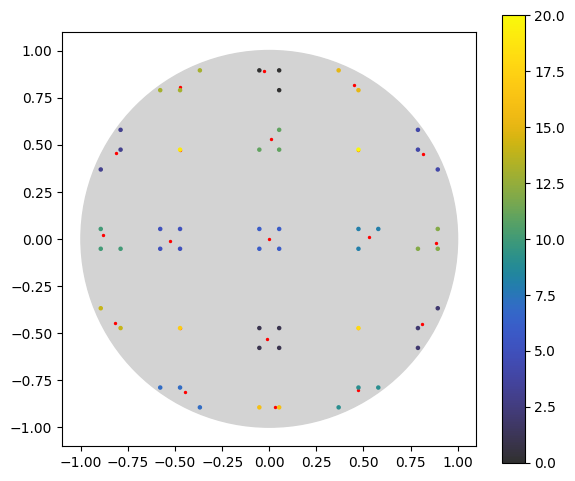

In [100]:
X = np.array([[nonzero_x[i] , nonzero_y[i]] for i in range(len(nonzero_x))])
score = float('-inf')
model = None
n_c = None
for n in range(2,len(nonzero_x)):
    kmeans = KMeans(n_clusters=n).fit(X)
    score_ = silhouette_score(X,kmeans.labels_)
    if score_ >= score:
        score = score_
        model = kmeans
        n_c = n

x_ = []
a_ = []
plt.figure(figsize=(6, 5))
plt.gca().add_artist(plt.Circle((0, 0), 1, color='lightgray'))
g_x , g_y , g_l = [] , [] , []
for label in range(n_c):
    group = model.labels_ == label
    ll = model.labels_[group]
    points = X[group]
    weights = nonzero_a[group]
    g_x.extend(points[:,0])
    g_y.extend(points[:,1])
    g_l.extend(ll)
    sum_w = weights.sum()
    x_.append((points.T@weights) / (sum_w))
    a_.append(sum_w)
x_ = np.array(x_)
a_ = np.array(a_)
plt.scatter(x_[:,0],x_[:,1],s=2,c='r')

plt.colorbar(plt.scatter(g_x , g_y  , s=5, c = g_l,cmap=cc.cm.gouldian  ))



plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

In [17]:
def Jacobian(point):
    n = len(point)
    x , y , w = point[:n//3] , point[n//3:n*2//3] , point[n*2//3:] 
    J = np.zeros((len(P) , n))
    for i in range(len(P)):
        power1 , power2 , power3 = P[i] , Px[i] , Py[i]
        dx , dy = np.zeros(n//3) , np.zeros(n//3)
        p1 , p2 = power1
        dw = -x**p1*y**p2
        if power2 != 0:
            p1,p2 = power2
            dx = -w*(x**p1*y**p2)
        if power3 != 0:
            p1,p2 = power3
            dy = -w*(x**p1*y**p2)
        dr = np.concatenate([dx,dy,dw])
        J[i] = dr
    return J

def residual_f(point):
    n = len(point)
    x , y , w = point[:n//3] , point[n//3:n*2//3] , point[n*2//3:] 
    r = np.zeros(len(P))
    for i in range(len(P)):
        p1 , p2 = P[i] 
        r[i] = b_eq[i] - np.dot(w , x**p1*y**p2)
    return r

x_x = x_[:,0]
x_y = x_[:,1]
initial = np.concatenate([x_x , x_y , a_])
point = initial.copy()
for i in range(10000):
    R = residual_f(point)
    residual = (R**2).sum()
    if i%100 == 0:
        print(f'iter: {i} , residual:{residual}')
    if residual < 1e-15:
        print(f'Converge: iter: {i} , residual:{residual}')
        break
    J = Jacobian(point)
    _ = np.linalg.pinv(J)@R
    # mul = lambda x: J.T@(J@x)
    # Jt_J = scipy.sparse.linalg.LinearOperator(
    #     shape=(len(point), len(point)), matvec=mul, rmatvec=mul, matmat=mul, rmatmat=mul)
    # _ = scipy.sparse.linalg.cg(Jt_J, J.T@R, tol=min(1e-10, residual))[0]
    point -= _


iter: 0 , residual:9.255129049951032e-06
iter: 100 , residual:3.517417244061589
iter: 200 , residual:3.259496920550817
iter: 300 , residual:3.553862324412622
iter: 400 , residual:3.5505768888010745
iter: 500 , residual:3.6160752879343754
iter: 600 , residual:3.571963153183268
iter: 700 , residual:3.738285380647733
iter: 800 , residual:3.697532798241995
iter: 900 , residual:3.9815290308028466
iter: 1000 , residual:3.954374527852455
iter: 1100 , residual:3.7049961272266376
iter: 1200 , residual:3.659571686204922
iter: 1300 , residual:3.6876809143369824
iter: 1400 , residual:3.9616788772377065
iter: 1500 , residual:3.829924039421481
iter: 1600 , residual:3.9109398060080514
iter: 1700 , residual:3.907814713169002
iter: 1800 , residual:3.7862541519515487
iter: 1900 , residual:3.754869639040069
iter: 2000 , residual:3.744373482593087
iter: 2100 , residual:3.832269244895093
iter: 2200 , residual:3.703963105749945
iter: 2300 , residual:3.7111350297739163
iter: 2400 , residual:3.637456595204523

In [8]:
N = len(_)
qx , qy , qw = initial[:N//3] , initial[N//3:N*2//3] , initial[N*2//3:] 
res = 0


In [9]:
np.dot(qw , qx**0*qy**0)

3.1415926535897936

In [10]:
qw

array([0.25522141, 0.25522141, 0.13816188, 0.20534461, 0.06478506,
       0.20534461, 0.20230134, 0.25522141, 0.05983473, 0.25096719,
       0.25522141, 0.06561538, 0.06561538, 0.06478506, 0.13816188,
       0.13816188, 0.06066504, 0.06066504, 0.13816188, 0.05983473,
       0.20230134])

In [11]:
N = len(_)
qx , qy , qw = point[:N//3] , point[N//3:N*2//3] , point[N*2//3:] 
res = 0
np.dot(qw , qx**0*qy**0)

3.1400279618198557

In [12]:
qw

array([ 7.21140988e-12,  1.16566741e-11,  5.18605224e-01,  6.95400105e-01,
        9.25106341e-01,  4.93872203e-01,  2.47574646e-03,  5.57754238e-11,
        1.98635356e-13, -2.64564641e-02,  4.88733398e-11,  6.26490617e-03,
       -1.80032228e-03,  5.34801828e-01, -3.42377376e-03, -5.78083381e-03,
       -2.50055302e-05, -7.51027607e-05,  2.25365884e-05, -1.19147080e-12,
        1.04057345e-03])

# In squre

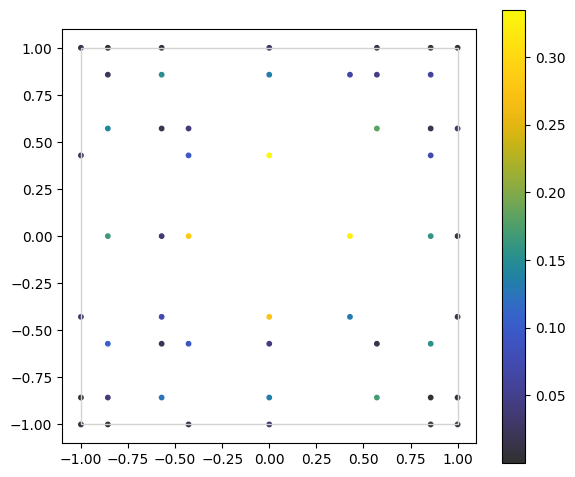

In [86]:
m = 10
M = 15
# Dirac measure
dirac = lambda X,x: int(x in X)

# Monomials and q(P^(j))
def ps(n):
    p , q= [] , []
    for i in range(n):
        for j in range(n-i):
            p.append((i , j))
            if j % 2 == 1 or i % 2 == 1:
                q.append(0)
            else:
                a_i , a_j = i , j
                b_i , b_j = (a_i + 1) / 2 , (a_j + 1) / 2
                q.append(4 / ((j + 1) * (i + 1)))
    return p , np.array(q,dtype=float)
P , b_eq = ps(m)

# Sample points with a small mesh size
_ = np.linspace(-1,1,M)
sx , sy = np.meshgrid(_ , _)
sx = sx.flatten()
sy = sy.flatten()

# Sensitivity function
r = lambda x , y: x ** (m) + y ** (m)
# Coefficients of \mu(r)
c = r(sx , sy)
# Equality constraint
A_eq = np.array([sx ** i * sy ** j for i,j in P])
alpha = scipy.optimize.linprog(c , A_eq=A_eq , b_eq=b_eq , bounds=(0,np.inf)).x
nozero = alpha != 0
nonzero_a = alpha[nozero]
nonzero_x , nonzero_y= sx[nozero] , sy[nozero]
plt.figure(figsize=(6, 5))
plt.scatter(nonzero_x,nonzero_y , 10, nonzero_a, cmap=cc.cm.gouldian,
zorder=1)
plt.gca().add_patch(Rectangle((-1,-1),2,2,linewidth=1,edgecolor='lightgray',facecolor='none'))

plt.colorbar()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('s.png')
plt.show()


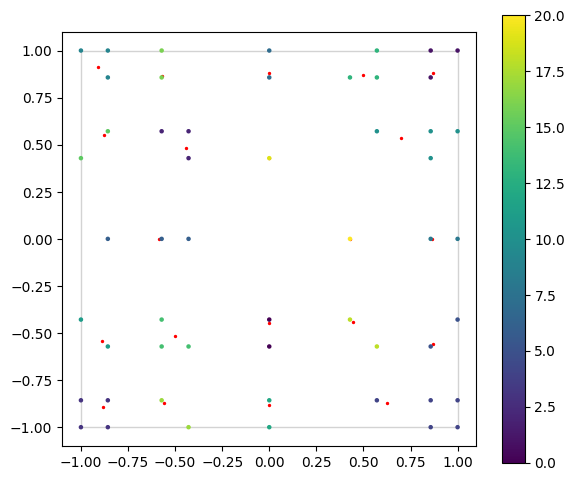

In [90]:
X = np.array([[nonzero_x[i] , nonzero_y[i]] for i in range(len(nonzero_x))])
score = float('-inf')
model = None
n_c = None
for n in range(2,len(nonzero_x)):
    kmeans = KMeans(n_clusters=n).fit(X)
    score_ = silhouette_score(X,kmeans.labels_)
    if score_ >= score:
        score = score_
        model = kmeans
        n_c = n

x_ = []
a_ = []
plt.figure(figsize=(6, 5))
plt.gca().add_patch(Rectangle((-1,-1),2,2,linewidth=1,edgecolor='lightgray',facecolor='none'))
g_x , g_y , g_l = [] , [] , []
for label in range(n_c):
    group = model.labels_ == label
    ll = model.labels_[group]
    points = X[group]
    weights = nonzero_a[group]
    g_x.extend(points[:,0])
    g_y.extend(points[:,1])
    g_l.extend(ll)
    sum_w = weights.sum()
    x_.append((points.T@weights) / (sum_w))
    a_.append(sum_w)
x_ = np.array(x_)
a_ = np.array(a_)
plt.scatter(x_[:,0],x_[:,1],s=2,c='r')
plt.colorbar(plt.scatter(g_x , g_y  , s= 5, c = g_l )
)


plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

In [93]:
def Jacobian(point):
    n = len(point)
    x , y , w = point[:n//3] , point[n//3:n*2//3] , point[n*2//3:] 
    J = np.zeros((len(P) , n))
    for i in range(len(P)):
        power1 , power2 , power3 = P[i] , Px[i] , Py[i]
        dx , dy = np.zeros(n//3) , np.zeros(n//3)
        p1 , p2 = power1
        dw = -x**p1*y**p2
        if power2 != 0:
            p1,p2 = power2
            dx = -w*(x**p1*y**p2)
        if power3 != 0:
            p1,p2 = power3
            dy = -w*(x**p1*y**p2)
        dr = np.concatenate([dx,dy,dw])
        J[i] = dr
    return J

def residual_f(point):
    n = len(point)
    x , y , w = point[:n//3] , point[n//3:n*2//3] , point[n*2//3:] 
    r = np.zeros(len(P))
    for i in range(len(P)):
        p1 , p2 = P[i] 
        r[i] = b_eq[i] - np.dot(w , x**p1*y**p2)
    return r

def line_search(p,point):
    alpha = .1
    while (residual_f(point + alpha*p) > residual_f(point) + 0.3 * alpha * Jacobian(point)@p).any():
        alpha *= 0.1
        if alpha <= 1e-6:
            break
    return alpha


x_x = x_[:,0]
x_y = x_[:,1]
initial = np.concatenate([x_x , x_y , a_])
point = initial.copy()
for i in range(10000):
    R = residual_f(point)
    residual = (R**2).sum()
    if i%200 == 0:
        print(f'Converge: iter: {i} , residual:{residual}')
    if residual < 1e-15:
        
        break
    J = Jacobian(point)
    _ = np.linalg.pinv(J)@R
    alpha = line_search(_,point)
    # mul = lambda x: J.T@(J@x)
    # Jt_J = scipy.sparse.linalg.LinearOperator(
    #     shape=(len(point), len(point)), matvec=mul, rmatvec=mul, matmat=mul, rmatmat=mul)
    # _ = scipy.sparse.linalg.cg(Jt_J, J.T@R, tol=min(1e-10, residual))[0]
    point -= alpha*_ 


Converge: iter: 0 , residual:0.05122265713429471
Converge: iter: 200 , residual:2301691335685.7
Converge: iter: 400 , residual:2301330292296.0713
Converge: iter: 600 , residual:2300439880523.11


KeyboardInterrupt: 

In [111]:
N = len(_)
qx , qy , qw = point[:N//3] , point[N//3:N*2//3] , point[N*2//3:] 
res = 0
np.dot(qw , qx**0*qy**0)

3.141592653589903

In [99]:
N = len(_)
qx , qy , qw = initial[:N//3] , initial[N//3:N*2//3] , initial[N*2//3:] 
res = 0
np.dot(qw , qx**0*qy**0)

3.1415926535897913